In [1]:
import os
import nvtabular as nvt
from nvtabular.ops import Rename, Filter, Dropna, LambdaOp, Categorify, \
    TagAsUserFeatures, TagAsUserID, TagAsItemFeatures, TagAsItemID, AddMetadata

from merlin.schema.tags import Tags
from merlin.dag.ops.subgraph import Subgraph
import merlin.models.tf as mm
from merlin.io.dataset import Dataset
from merlin.datasets.ecommerce import transform_aliccp
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/numba/core/config.py:213: RuntimeWarning: Environment variable 'NUMBA_DISABLE_JIT' is defined but its associated value '"1"' could not be parsed.
The parse failed with exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numba/core/config.py", line 211, in _readenv
    return ctor(value)
ValueError: invalid literal for int() with base 10: '"1"'

  warnings.warn(f"Environment variable '{name}' is defined but "
2024-09-22 06:47:11.271557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 06:47:12.095790: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following i

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_FOLDER = os.environ.get("DATA_FOLDER", "/try-merlin/data/")
# set up the base dir for feature store
BASE_DIR = os.environ.get(
    "BASE_DIR", "/try-merlin/"
)

In [3]:
from merlin.datasets.synthetic import generate_data

NUM_ROWS = os.environ.get("NUM_ROWS", 100_000)
train_raw, valid_raw = generate_data("aliccp-raw", int(NUM_ROWS), set_sizes=(0.7, 0.3))

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


If you would like to use the real ALI-CCP dataset, you can use [get_aliccp()](https://github.com/NVIDIA-Merlin/models/blob/stable/merlin/datasets/ecommerce/aliccp/dataset.py) function instead. This function takes the raw csv files, and generate parquet files that can be directly fed to NVTabular workflow above.

In [5]:
# disable INFO and DEBUG logging everywhere
import logging

logging.disable(logging.WARNING)

## Set up a feature store with Feast
Before we move onto the next step, we need to create a Feast feature repository.[Feast](https://feast.dev/)t is an end-to-end open source feature store for machine learning. Feast (Feature Store) is a customizable operational data system that re-uses existing infrastructure to manage and serve machine learning features to real-time models.

We will create the feature repo in the current working directory, which `BASE_DIR`DIR for us.

In [6]:
!rm -rf $BASE_DIR/feast_repo
!cd $BASE_DIR && feast init feast_repo


Creating a new Feast repository in /try-merlin/feast_repo.



In [7]:
feature_repo_path = os.path.join(BASE_DIR, "feast_repo/feature_repo")
if os.path.exists(f"{feature_repo_path}/example_repo.py"):
    os.remove(f"{feature_repo_path}/example_repo.py")
if os.path.exists(f"{feature_repo_path}/data/driver_stats.parquet"):
    os.remove(f"{feature_repo_path}/data/driver_stats.parquet")

## Exporting user and item features

In [20]:
from merlin.models.utils.dataset import unique_rows_by_features

unique_rows_by_features(train_raw, Tags.USER, Tags.USER_ID)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [12]:
from merlin.models.utils.dataset import unique_rows_by_features

user_features = (
    unique_rows_by_features(train_raw, Tags.USER, Tags.USER_ID)
    .compute()
    .reset_index(drop=True)
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [13]:
from datetime import datetime

user_features["datetime"] = datetime.now()
user_features["datetime"] = user_features["datetime"].astype("datetime64[ns]")
user_features["created"] = datetime.now()
user_features["created"] = user_features["created"].astype("datetime64[ns]")

In [19]:
user_features[user_features['user_id']

,user_id,user_shops,user_profile,user_group,user_gender,user_age,user_consumption_1,user_consumption_2,user_is_occupied,user_geography,...,item_shop,item_brand,item_intention,user_item_categories,user_item_shops,user_item_brands,user_item_intentions,position,click,conversion
0,9,386,1,1,1,1,1,1,1,1,...,6918,2383,1102,331,194111,38662,6784,0,1,1
1,10,434,1,1,1,1,1,1,1,1,...,1153,398,184,5259,118163,115040,72901,0,1,1
2,15,674,1,1,1,1,1,1,1,1,...,11914,4103,1897,7466,196296,7256,22856,3,0,0
3,11,482,1,1,1,1,1,1,1,1,...,61104,21043,9730,783,301873,2691,60145,2,1,0
4,6,241,1,1,1,1,1,1,1,1,...,4996,1721,796,1336,322633,114312,21063,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,18,819,1,1,1,1,1,1,1,1,...,41504,14294,6609,2603,34121,66339,20654,1,0,1
69996,57,2696,3,1,1,1,1,1,1,1,...,5765,1986,918,6496,88300,78572,67470,2,0,0
69997,16,723,1,1,1,1,1,1,1,1,...,1538,530,245,540,275375,137510,43492,1,1,1
69998,3,97,1,1,1,1,1,1,1,1,...,11529,3971,1836,4458,239815,84287,2668,0,0,0


In [24]:
user_features.to_parquet(
    os.path.join(feature_repo_path, "data", "user_features.parquet")
)

In [25]:
item_features = (
    unique_rows_by_features(train_raw, Tags.ITEM, Tags.ITEM_ID)
    .compute()
    .reset_index(drop=True)
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [26]:
item_features["datetime"] = datetime.now()
item_features["datetime"] = item_features["datetime"].astype("datetime64[ns]")
item_features["created"] = datetime.now()
item_features["created"] = item_features["created"].astype("datetime64[ns]")

In [27]:
item_features.head()

,item_id,item_category,item_shop,item_brand,item_intention,datetime,created
0,19,99,6918,2383,1102,2024-09-22 06:58:11.766741,2024-09-22 06:58:11.768123
1,4,17,1153,398,184,2024-09-22 06:58:11.766741,2024-09-22 06:58:11.768123
2,32,170,11914,4103,1897,2024-09-22 06:58:11.766741,2024-09-22 06:58:11.768123
3,160,868,61104,21043,9730,2024-09-22 06:58:11.766741,2024-09-22 06:58:11.768123
4,14,71,4996,1721,796,2024-09-22 06:58:11.766741,2024-09-22 06:58:11.768123


In [28]:
# save to disk
item_features.to_parquet(
    os.path.join(feature_repo_path, "data", "item_features.parquet")
)

## Feature Engineering with NVTabular

In [29]:
output_path = os.path.join(DATA_FOLDER, "processed_nvt")

In [30]:
# Feed the user_id and item_id to the pipeline: Rename (add postfix "_raw") -> Casttype. And Mark these as Feature of Recsys
user_id_raw = ["user_id"] >> Rename(postfix='_raw') >> LambdaOp(lambda col: col.astype("int32")) >> TagAsUserFeatures()
item_id_raw = ["item_id"] >> Rename(postfix='_raw') >> LambdaOp(lambda col: col.astype("int32")) >> TagAsItemFeatures()

# Feed the item_id, item_category, item_shop, item_brand into the Categorify processing.
item_cat = Categorify(dtype="int32")
items = (["item_id","item_category", "item_shop", "item_brand"] >> item_cat)

column_mapping

input_dtypes

input_schema

leaf_nodes

output_dtypes

output_schemaput_schema

In [38]:
subgraph_item = Subgraph(
     "item", 
     Subgraph("items_cat", items) + 
    (items["item_id"] >> TagAsItemID()) + 
    (items["item_category", "item_shop", "item_brand"] >> TagAsItemFeatures())
)
subgraph_user = Subgraph(
    "user",
    (["user_id"] >> Categorify(dtype="int32") >> TagAsUserID()) +
    (
        [
            "user_shops",
            "user_profile",
            "user_group",
            "user_gender",
            "user_age",
            "user_consumption_2",
            "user_is_occupied",
            "user_geography",
            "user_intentions",
            "user_brands",
            "user_categories",
        ] >> Categorify(dtype="int32") >> TagAsUserFeatures()
    )
)

In [44]:
targets = ["click"] >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])
outputs = subgraph_user + subgraph_item + targets

# add dropna op to filter rows with nulls
outputs = outputs >> Dropna()
nvt_wkflow = nvt.Workflow(outputs)

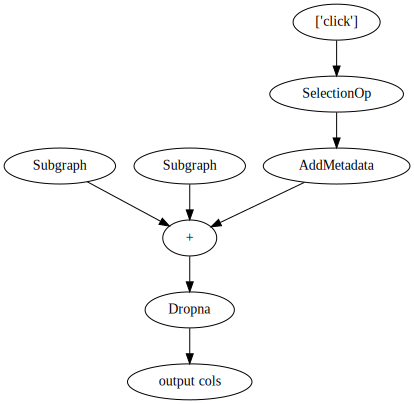

In [50]:
outputs.graph

Let’s call transform_aliccp utility function to be able to perform fit and transform steps on the raw dataset applying the operators defined in the NVTabular workflow pipeline below, and also save our workflow model. After fit and transform, the processed parquet files are saved to output_path.

In [53]:
transform_aliccp(
    (train_raw, valid_raw), output_path, nvt_workflow=nvt_wkflow, workflow_name="workflow"
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
Failed to fit operator <merlin.dag.ops.subgraph.Subgraph object at 0x7f9ef95a8070>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/merlin/dag/executors.py", line 530, in fit_phase
    stats.append(node.op.fit(node.input_columns, Dataset(ddf)))
  File "/usr/local/lib/python3.10/dist-packages/merlin/dag/ops/subgraph.py", line 75, in fit
    DaskExecutor().fit(dataset, self.graph)
  File "/usr/local/lib/python3.10/dist-packages/merlin/dag/executors.py", line 466, in fit
    self.fit_phase(dataset, current_phase)
  File "/usr/local/lib/python3.10/dist

AttributeError: can't set attribute 'dask'

## Training a Retrieval Model with Two-Tower Model

We start with the offline candidate retrieval stage. We are going to train a Two-Tower model for item retrieval. To learn more about the Two-tower model you can visit [05-Retrieval-Model.ipynb](https://github.com/NVIDIA-Merlin/models/blob/stable/examples/05-Retrieval-Model.ipynb).

We are going to process our raw categorical features by encoding them using Categorify() operator and tag the features with user or item tags in the schema file. To learn more about NVTabular and the schema object visit this example notebook in the Merlin Models repo. \
Define a new output path to store the filtered datasets and schema files.

https://github.com/NVIDIA-Merlin/NVTabular \
https://github.com/NVIDIA-Merlin/models/blob/stable/examples/02-Merlin-Models-and-NVTabular-integration.ipynb


In [31]:
output_path2 = os.path.join(DATA_FOLDER, "processed/retrieval")

In [55]:
train_tt = Dataset(os.path.join(output_path, "train", "*.parquet"))
valid_tt = Dataset(os.path.join(output_path, "valid", "*.parquet"))

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


IndexError: list index out of range

In [33]:
inputs = train_tt.schema.column_names
outputs = inputs >> Filter(f=lambda df: df["click"] == 1)

nvt_wkflow.fit(train_tt)

nvt_wkflow.transform(train_tt).to_parquet(
    output_path=os.path.join(output_path2, "train")
)

nvt_wkflow.transform(valid_tt).to_parquet(
    output_path=os.path.join(output_path2, "valid")
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limi

NVTabular exported the schema file, schema.pbtxt a protobuf text file, of our processed dataset. To learn more about the schema object and schema file you can explore 02-Merlin-Models-and-NVTabular-integration.ipynb notebook.

https://github.com/NVIDIA-Merlin/models/blob/stable/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [34]:
train_tt = Dataset(os.path.join(output_path2, "train", "*.parquet"), part_size="500MB")
valid_tt = Dataset(os.path.join(output_path2, "valid", "*.parquet"), part_size="500MB")

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [35]:
schema = train_tt.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER]).without(['click'])
train_tt.schema = schema
valid_tt.schema = schema

In [40]:
model_tt = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

In [41]:
model_tt.compile(
    optimizer="adam",
    run_eagerly=False,
    loss="categorical_crossentropy",
    metrics=[mm.RecallAt(10), mm.NDCGAt(10)],
)
model_tt.fit(train_tt, validation_data=valid_tt, batch_size=1024 * 8, epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2024-09-21 10:43:50.067645: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - ETA: 0s - loss: 8.9539 - recall_at_10: 0.0130 - ndcg_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 8.9251

2024-09-21 10:44:13.356851: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 30s 2s/step - loss: 8.9539 - recall_at_10: 0.0132 - ndcg_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 8.8711 - val_loss: 8.9179 - val_recall_at_10: 0.0212 - val_ndcg_at_10: 0.0164 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 8.5806


In [42]:
query_tower = model_tt.retrieval_block.query_block()
query_tower.save(os.path.join(BASE_DIR, "query_tower"))

## Training a Ranking Model with DLRM

In [43]:
# define train and valid dataset objects
train = Dataset(os.path.join(output_path, "train", "*.parquet"), part_size="500MB")
valid = Dataset(os.path.join(output_path, "valid", "*.parquet"), part_size="500MB")

# define schema object
schema = train.schema

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [44]:
target_column = schema.select_by_tag(Tags.TARGET).column_names[0]
target_column

'click'

Deep Learning Recommendation Model (DLRM) architecture is a popular neural network model originally proposed by Facebook in 2019. The model was introduced as a personalization deep learning model that uses embeddings to process sparse features that represent categorical data and a multilayer perceptron (MLP) to process dense features, then interacts these features explicitly using the statistical techniques proposed in here. To learn more about DLRM architetcture please visit `Exploring-different-models` notebook in the Merlin Models GH repo.

https://arxiv.org/abs/1906.00091 \
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&amp;arnumber=5694074 \
https://github.com/NVIDIA-Merlin/models/blob/stable/examples/04-Exporting-ranking-models.ipynb

In [45]:
model = mm.DLRMModel(
    schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [46]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=16 * 1024)

2024-09-21 10:47:54.879876: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - ETA: 0s - loss: 0.6932 - auc: 0.5000 - regularization_loss: 0.0000e+00 - loss_batch: 0.6932

2024-09-21 10:47:59.860910: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 6s 370ms/step - loss: 0.6932 - auc: 0.5000 - regularization_loss: 0.0000e+00 - loss_batch: 0.6932 - val_loss: 0.6932 - val_auc: 0.4983 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.6932


In [47]:
model.save(os.path.join(BASE_DIR, "dlrm"))

In the following cells we are going to export the required user and item features files, and save the query (user) tower model and item embeddings to disk. If you want to read more about exporting retrieval models, please visit 05-Retrieval-Model.ipynb notebook in Merlin Models library repo.

https://github.com/NVIDIA-Merlin/models/blob/stable/examples/05-Retrieval-Model.ipynb

## Extract and save Item embeddings

In [48]:
from merlin.systems.dag.ops.tensorflow import PredictTensorflow
from merlin.systems.dag.ops.workflow import TransformWorkflow

workflow =  nvt.Workflow(["item_id"] + (['item_id', 'item_brand', 'item_category', 'item_shop'] >> TransformWorkflow(nvt_wkflow.get_subworkflow("item")) >> PredictTensorflow(model_tt.first.item_block())))
item_embeddings = workflow.fit_transform(Dataset(item_features)).to_ddf().compute()

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [54]:
try:
    print(item_embeddings.tail())
except AttributeError:
    pass

     item_id                                           output_1
453      309  [0.029576169326901436, 0.006714393850415945, -...
454      591  [0.00835354346781969, -0.0035651458892971277, ...
455      329  [0.025229154154658318, 0.004694434814155102, -...
456      401  [0.01725717820227146, -0.00310110324062407, -0...
457      641  [0.00835354346781969, -0.0035651458892971277, ...


In [55]:
# save to disk
item_embeddings.to_parquet(os.path.join(BASE_DIR, "item_embeddings.parquet"))

## Create feature definitions

In [62]:
%%writefile /try-merlin/feast_repo/feature_repo/user_features.py

from datetime import timedelta
from feast import Entity, Field, FeatureView, ValueType
from feast.types import Int32
from feast.infra.offline_stores.file_source import FileSource

user_features = FileSource(
    path="/try-merlin/feast_repo/feature_repo/data/user_features.parquet",
    timestamp_field="datetime",
    created_timestamp_column="created",
)

user = Entity(name="user_id", value_type=ValueType.INT32, join_keys=["user_id"],)

user_features_view = FeatureView(
    name="user_features",
    entities=[user],
    ttl=timedelta(0),
    schema=[
        Field(name="user_shops", dtype=Int32),
        Field(name="user_profile", dtype=Int32),
        Field(name="user_group", dtype=Int32),
        Field(name="user_gender", dtype=Int32),
        Field(name="user_age", dtype=Int32),
        Field(name="user_consumption_2", dtype=Int32),
        Field(name="user_is_occupied", dtype=Int32),
        Field(name="user_geography", dtype=Int32),
        Field(name="user_intentions", dtype=Int32),
        Field(name="user_brands", dtype=Int32),
        Field(name="user_categories", dtype=Int32),
    ],
    online=True,
    source=user_features,
    tags=dict(),
)

Overwriting /try-merlin/feast_repo/user_features.py


In [64]:
%%writefile /try-merlin/feast_repo/feature_repo/item_features.py

from datetime import timedelta
from feast import Entity, Field, FeatureView, ValueType
from feast.types import Int32
from feast.infra.offline_stores.file_source import FileSource

item_features = FileSource(
    path="/try-merlin/feast_repo/feature_repo/data/item_features.parquet",
    timestamp_field="datetime",
    created_timestamp_column="created",
)

item = Entity(name="item_id", value_type=ValueType.INT32, join_keys=["item_id"],)

item_features_view = FeatureView(
    name="item_features",
    entities=[item],
    ttl=timedelta(0),
    schema=[
        Field(name="item_category", dtype=Int32),
        Field(name="item_shop", dtype=Int32),
        Field(name="item_brand", dtype=Int32),
    ],
    online=True,
    source=item_features,
    tags=dict(),
)

Writing /try-merlin/feast_repo/item_features.py


In [65]:
# install seedir
!pip install seedir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 1.9 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [66]:
import seedir as sd

feature_repo_path = os.path.join(BASE_DIR, "feast_repo")
sd.seedir(
    feature_repo_path,
    style="lines",
    itemlimit=10,
    depthlimit=3,
    exclude_folders=".ipynb_checkpoints",
    sort=True,
)

feast_repo/
├─README.md
├─__init__.py
├─feature_repo/
│ ├─__init__.py
│ ├─__pycache__/
│ │ ├─__init__.cpython-310.pyc
│ │ ├─example_repo.cpython-310.pyc
│ │ └─test_workflow.cpython-310.pyc
│ ├─data/
│ │ ├─item_features.parquet
│ │ └─user_features.parquet
│ ├─feature_store.yaml
│ └─test_workflow.py
├─item_features.py
└─user_features.py


We trained and exported our ranking and retrieval models and NVTabular workflows. In the next step, we will learn how to deploy our trained models into Triton Inference Server (TIS) with Merlin Systems library.

For the next step, move on to the 02-Deploying-multi-stage-Recsys-with-Merlin-Systems.ipynb notebook to deploy our saved models as an ensemble to TIS and obtain prediction results for a given reques

https://github.com/triton-inference-server/servert.